# Introduction

Welcome!

In this tutorial, we'll look at fitting models of ionic currents using voltage-clamp data, i.e., currents measured in experiments where a cell's membrane potential is controlled by the experimenter.

The examples start quite simple, but build up in complexity as we go along.

## The model

The next section describes the model equations. If you like, you can skip past this and go straight to the model implementation below.

For all of this tutorial, we use a simple two-gate Hogdkin-Huxley model to describe channel kinetics, and an Ohmic term to describe the driving force:

$$I(V, t) = g_\text{max} \cdot a(V, t) \cdot r(V, t) \cdot (V - E)$$

Here $g_\text{max}$ is the maximum conductance, determined by the number of channels and the conductance per channel, but assumed constant for this tutorial.

The variables $a$ and $r$ are dimensionless variables that vary between 0 and 1, and describe the fraction of channels in an _activated_ (a) or _recovered_ (r) state.
The underlying assumpution is that the current kinetics are described by two independent processes called "activation" and "inactivation", and that channels must be "activated" and "recovered from inactivation" to conduct.

Taken together, $g_\text{max} \cdot a \cdot r$ represent the combined conductance of the channel, so that $I = g(V, t) \cdot (V - E)$, or $I = g \Delta{V}$.
In other words, we assume that when a channel is open, the current through the channel is a passive current, linearly proportional to a voltage difference $(V - E)$, where $E$ is the Nernst or reversal potential, and is determined by the balance of _diffusion_ (particles moving randomly will eventually spread out more or less evenly) and the electrotonic attraction and repulsion caused by the particles' charges.

For most of this tutorial, we'll assume that $g_\text{max}$ and the parameters in the equations for $a$ and $r$ need to be identified, while the reversal potential $E$ can be estimated from the internal and external solutions used in the experiment.

<img src="resources/gating.png" width="552px" />

The variables $a$ and $b$ are both described as simple chemical processes that can be in one of two states: _open_ (O) or _closed_ (C).
Each state has a certain energy associated with it, and to make the transition between the two states an energy barrier needs to be overcome.
The size of this barrier determines the transition rates in both directions $k_1$ and $k_2$.

In (physical) chemistry, this is commonly described using the transition state theory, e.g. with the [Eyring equation](https://en.wikipedia.org/wiki/Eyring_equation) (with an added term for the electrical energy, see [Tsien & Noble 1969](https://link.springer.com/article/10.1007/BF01869785)).
The resulting rate equations contain a mixture of physical constants and model parameters, but can be reduced to the form

$$k_i = a_i \cdot e ^ {b_i \cdot V} $$


We can use rate equations of this form to write a differential equation for activation.
Using $a$ for the fraction of activated channels, we see that the fraction of channels _not_ activation must be $1 - a$.
Then, setting $k_1$ as the rate at which channels activate, and $k_2$ as the rate at which channels deactivate, we can write

$$\frac{da}{dt} = (1 - a) k_1 - a k_2$$

Here, $a$ is dimensionless, while the rates $k_i$ have units of 1-over-time.
To get a bit more insight into the equation, it's commonly rewritten as

$$\frac{da}{dt} = k_1 - (k_1 + k_2) a = \frac{\frac{k1}{k1 + k2} - a}{\frac{1}{k_1 + k_2}} = \frac{a_\infty - a}{\tau_a}$$

This equation is positive when $a < a_\infty$, which will cause $a$ to move towards $a_\infty$ over time.
Similarly, it's negative when $a > a_\infty$, so that again $a$ moves towards $a_\infty$.
When $a = a_\infty$ the rate of change is zero.
In other words, $a_\infty$ is the action variable's _steady state_.

The rate at which it moves towards its steady state is determined by $\tau_a$, where a _larger_ value of $\tau_a$ will cause the rate to be _slower_.

Following [the 2017 paper by Beattie et al.](https://doi.org/10.1113/JP276068) we write a similar equation for the recovery variable as:

$$\frac{dr}{dt} = (1 - r) k_4 - r k_3 = \frac{r_\infty - r}{\tau_r}$$

### The full model

The full model equations are:

$$ I = g_\text{max} \cdot a \cdot r \cdot (V - E) $$

\begin{align}
\dot{a} = (1 - a)k_1 - a k_2    &&& k1 = p_1 \exp(p_2 V) \\
                                &&& k2 = p_3 \exp(-p_4 V) \\
\dot{r} = (1 - r)k_4 - r k_4    &&& k3 = p_5 \exp(p_6 V) \\
                                &&& k4 = p_7 \exp(-p_8 V)
\end{align}

$$p_9 = g_\text{max} $$

### Gotcha: "a priori unidentifiability"

The best way to model an ion current is still an open question.
Many modelling studies have used much more complex rate equations than $k = a e ^ {b V}$.
A physical argument for these forms is not often given, so that it's difficult to determine whether these forms are really justified, or if maybe the same effect could (should?) have been obtained by using a more complex model structure).

One nice thing about the $k = a e ^ {b V}$ form is that it decomposes each rate into just two bits of information: $a$ describes the overal rate of the transition, while $b$ describes its voltage dependence.
If voltage is the only thing we vary during an experiment, this is probably the simplest form in which we can capture our observations.
If temperature is also varied, the same reasoning (Eyring rate theory) leads naturally to a three-parameter form (see e.g. [Lei et al., BiophysJ 2019](https://doi.org/10.1016/j.bpj.2019.07.030)).

The choice of equations has a direct effect on how well we can parametrise the models.
A model with too few parameters will never be able to fit the data.
However, if a model has too many parameters, there will be multiple parameter sets that give the same result, rendering the "correct" parameter set _unidentifiable_.
Determining whether a problem is identifiable or not can be difficult (see e.g. https://doi.org/10.1098/rsta.2008.0301), but there are a few examples that appear in the literature where a model can be seen to be unidentifiable just by inspecting the equations.
This is sometimes called _a priori unidentifiability_.

A simple example of a priori unidentifiability is:

$$k = p e ^ {q + rV}$$

The form above can be rewritten as $(p e^q)e^{rV} = a e^{bV}$ so that it reduces to the two parameter form.
Only now there are infinitely many combinations $p e^q$ that give the same value for $a$.
Using this formulation could make life unnecessarily difficult for an optimisation algorithm, but would also cause difficulty when comparing the results of repeated fits, e.g. fits to new data.

## The model implementation

Now that we've defined the maths, we code up the model using [myokit](http://myokit.org).
We'll use a file adapted from ["Four ways to fit an ion channel model"](https://doi.org/10.1016/j.bpj.2019.08.001).

The full model is provided in [resources/beattie-2017-ikr-hh.mmt](./resources/beattie-2017-ikr-hh.mmt).
The main part looks like this:


```
[ikr]
use membrane.V
IKr = g * act * rec * (V - nernst.EK)
    in [nA]
dot(act) = (inf - act) / tau
    inf = k1 * tau
    tau = 1 / (k1 + k2)
    k1 = p1 * exp(p2 * V)
    k2 = p3 * exp(-p4 * V)
dot(rec) = (inf - rec) / tau
    inf = k4 * tau
    tau = 1 / (k3 + k4)
    k3 = p5 * exp(p6 * V)
    k4 = p7 * exp(-p8 * V)
p1 = 2.26e-4 [1/ms]
p2 = 0.0699 [1/mV]
p3 = 3.45e-5 [1/ms]
p4 = 0.05462 [1/mV]
p5 = 0.0873 [1/ms]
p6 = 8.91e-3 [1/mV]
p7 = 5.15e-3 [1/ms]
p8 = 0.03158 [1/mV]
p9 = 0.1524 [uS]
g = p9
```

Here, the current is called ``IKr`` and the parameters are taken from ["Sinusoidal voltage protocols for rapid characterisation of ion channel kinetics"](https://doi.org/10.1113/JP275733).

Later, we'll fit this model to current measured in cells expressing the hERG gene, which encodes the $\alpha$ subunit of the channel carrying $I_\text{Kr}$ in real myocytes.
The "true" $I_\text{Kr}$ current is formed from more than just an $\alpha$-subunit, so it's important to remember that these measurements are an imperfect proxy for the real thing - what biologists would call a _model_.
So when interpreting simulations with the model above, it's important to remember we're dealing with a (mathematical) model of a (biological) model of the real thing.
For this tutorial, where we focus only on fitting, we'll have to keep this in our mind and use $I_Kr$ (or ``IKr``) as a short-hand for the currents measured in our expression system experiments.

## A first protocol: A simplified Lei et al. "staircase"

We now introduce a first voltage "protocol", i.e. the signal that the cell membrane will be subjected to while we measure the currents arising in response.
Several protocols have been used in the literature, and a few popular ones for $I_\text{Kr}$ are analysed in ["Four ways to fit an ion channel model"](https://doi.org/10.1016/j.bpj.2019.08.001) (particularly the supplement).

For this tutorial, we'll start with a simplified variant of the "staircase protocol" by Chon Lok Lei, as used in [Rapid characterisation of hERG channel kinetics](https://doi.org/10.1016/j.bpj.2019.07.029).
We'll use this to set up our simulation, and run some synthetic experiments.
More protocols - and the best way to simulate them - are discussed LINK LINK LINK.

An `mmt` file for the simplified staircase can be found at [resources/simplified-staircase.mmt](resources/simplified-staircase.mmt).
You can inspect the source for this protocol by opening the file in Myokit's IDE and switching to the protocol tab.
A nicer way to view it in the IDE is to plot a preview by hitting "Ctrl+P".

Alternatively, we can make this plot manually, using the method [Protocol.log_for_interval()](https://myokit.readthedocs.io/api_simulations/Protocol.html#myokit.Protocol.log_for_interval):


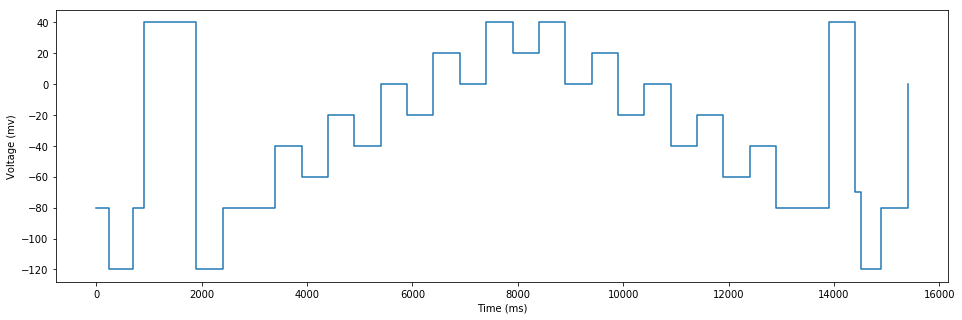

In [3]:
import matplotlib.pyplot as plt
import myokit

# Load the protocol
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')

# Get the duration of the protocol
t = protocol.characteristic_time()

# Get a simulation log with data points representing the protocol
log = protocol.log_for_interval(0, t, for_drawing=True)

plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mv)')
plt.plot(log['time'], log['pace'])
plt.show()

Comparing this protocol to the one shown in Figure 1 of the "Rapid characterization" paper, we can spot two big differences:

1. An important difference: The original staircase protocol contains two ramps, a "leak ramp" (at the start of the protocol) and a "reversal ramp" (at the end of the protocol). These ramps provide useful information to determine the size of the leak current, and to improve estimates of the reversal potential.

2. An annoying difference: At the end of the plot, the protocol seems to shoot up to 0mV, even though this is never specified by the `mmt` file. 

What's going on? Careful reading of the docs shows us that the `log_for_interval` method returns data for a _closed interval_, containing both the initial and the final requested point. But steps of a `myokit.Protocol` are defined as half-open: they specify the voltage at the starting point of each step, right up until _but not including_ the voltage at the end of each step. Points that are not defined explicitly by the protocol are taken to be 0, explaining the apparent jump to 0mV at end of our plot. Implementation details like these are annoying, but crop up quite often when fitting, so it's good to be aware of them!

## Summary

In this part of the tutorial we have

- Described a two-state Hodgkin-Huxley model with 9 parameters
- Seen a Myokit implementation of the model
- Seen an example of the first "gotcha": a priori unidentifiability
- Introduced a simplfied "staircase protocol"

In the next part of the tutorial we'll use these ingredients to perform some simulations.